<center><h1 style:"text-align:center;">Formulación 1</h1></center>
<center><h3>Relé 1</h3></center>


### 1. Imports


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# Métricas
from torchmetrics.functional.classification import binary_stat_scores

# Visualizar datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Progress bar
from tqdm import tqdm

# Acceder al sistema operativo
import os
import glob
import shutil
import random

d:\PaperLSTM\pyTorch\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Model Parameters


In [45]:
# LSTM parameters
hidden_dim = 20
n_signals = 3
N = 64

# _batch_size => m in figure 1.
train_batch_size = 64
dev_batch_size = 16
test_batch_size = 16

# Classification type (binary)
tagset_size = 1

# Set
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# database_information
total_windows = 81
max_window_idx = 14  # utilizar (m-N)//step + 1 (restarle 2, pues las primeras dos ventanas de falla no tienen info relevante de la falla, no se aprecia)
csv_step = 13

cpu


### 3. Model Creation


##### 3.1. FaultDetector Class Creation


In [18]:
# Model Creation


class FaultDetector(nn.Module):
    """Information about FaultDetector"""

    def __init__(self, n_signals, hidden_dim, tagset_size):
        super(FaultDetector, self).__init__()
        self.lstm = nn.LSTM(n_signals, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        # self.norm = nn.BatchNorm1d(tagset_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        fc_layer = self.fc(lstm_out[:, -1, :])
        # norm_layer = self.norm(fc_layer)

        return torch.sigmoid(fc_layer)

##### 3.2. Model Instance Initialization


In [19]:
model = FaultDetector(n_signals, hidden_dim, tagset_size).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Learning rate decay (optional)
decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer, gamma=decayRate
)

print(f"Model structure: {model}\n")

# Number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters: {params}")

Model structure: FaultDetector(
  (lstm): LSTM(3, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

Number of parameters: 2021


### 4. Dataset Creation


##### 4.1. Dataset Class Creation


In [20]:
# from utils.signalload import CSV_pandas_path
# from utils.auxfunctions import moving_window
from utils_tesis.signalload import CSV_pandas_path
from utils_tesis.auxfunctions import moving_window
import numpy as np
from itertools import repeat
import random


class Form1Dataset(torch.utils.data.Dataset):
    """Some Information about Form1Dataset"""

    def __init__(
        self,
        dataset_dir: str,
        signal_names: list[str],
        max_window_idx: int = 65,
        window_length: int = 64,
        step: int = 1,
        test: bool = False,
        dataset_size: int = 999999,
        csv_step: int = 8,
    ):
        super(Form1Dataset, self).__init__()

        self.signal_names = signal_names
        self.max_window_idx = max_window_idx
        self.dataset_dir = dataset_dir
        self.test = test
        self.csv_step = csv_step

        # Find all csv in folders of DataSet
        file_set = set()
        for dir_, _, files in os.walk(dataset_dir):
            for file_name in files:
                rel_dir = os.path.relpath(dir_, dataset_dir)
                rel_file = os.path.join(rel_dir, file_name)
                file_set.add(rel_file)
        csv_list = list(file_set)

        if dataset_size < len(csv_list):
            csv_list = random.sample(csv_list, dataset_size)
            # csv_list = csv_list[:dataset_size]
        self.csv_list = csv_list
        self.csv_amount = len(csv_list)
        self.windows_amount = max_window_idx * self.csv_amount
        self.window_length = window_length
        self.step = step

    def __getitem__(self, index, data_plot=False):
        # sample_settings
        window_length = self.window_length
        step = self.step

        # calculate window_idx and filename
        window_idx = index % self.max_window_idx
        csv_idx = index // self.max_window_idx
        csv_full_path = f"{self.dataset_dir}\{self.csv_list[csv_idx]}"

        # Load CSV, signal and create windows
        csv_name = os.path.basename(csv_full_path)
        signals_windows = np.empty((self.window_length, 0))

        # Load Change Event

        if "L_T" in self.csv_list[csv_idx]:
            for signal_name in self.signal_names:
                signal, t, _ = CSV_pandas_path(
                    csv_full_path, step=self.csv_step
                ).load_data(signal_name)
                # select window
                # len_ = len(signal)
                signal_window = signal[
                    -self.window_length
                    - self.max_window_idx
                    + window_idx
                    - 1 : -self.max_window_idx
                    + window_idx
                    - 1
                ]
                signal_window = np.expand_dims(signal_window, axis=1)
                signals_windows = np.append(signals_windows, signal_window, axis=1)

            # Create labels

            label = np.array([0])

        # Fault Event
        elif "F_T" in self.csv_list[csv_idx]:
            # For faults indices 0 and 1 don't contain fault events.
            for signal_name in self.signal_names:
                signal, t, _ = CSV_pandas_path(
                    csv_full_path, step=self.csv_step
                ).load_data(signal_name)
                # select window
                signal_window = signal[
                    -self.window_length
                    - self.max_window_idx
                    + window_idx : -self.max_window_idx
                    + window_idx
                ]
                signal_window = np.expand_dims(signal_window, axis=1)
                signals_windows = np.append(signals_windows, signal_window, axis=1)

            # Create labels
            label = np.array([1])

        signals_windows = torch.from_numpy(np.copy(signals_windows)).float()
        label = torch.from_numpy(label).float()
        t_window = moving_window(t, window_length, step)
        t_window = t_window[window_idx]
        # For Dataset Visualization
        if data_plot == True:
            return signals_windows.reshape(-1).numpy(), t_window
        if self.test == True:
            return signals_windows, t_window, label, csv_name, index, window_idx

        return signals_windows, label

    def get_event(self, csv_idx):
        # Get indices
        idx_min = csv_idx * self.max_window_idx
        idx_max = ((csv_idx + 1) * self.max_window_idx) - 1

        # Get path of csv_index
        csv_full_path = f"{self.dataset_dir}\{self.csv_list[csv_idx]}"

        # Load CSV, signal and create windows
        csv_name = os.path.basename(csv_full_path)
        signals = np.zeros((0, 0))
        for idx, signal_name in enumerate(self.signal_names):
            signal, t, _ = CSV_pandas_path(csv_full_path, step=self.csv_step).load_data(
                signal_name
            )
            signal = np.expand_dims(signal, axis=1)
            if idx == 0:
                signals = np.empty((len(signal), 0))
            signals = np.append(signals, signal, axis=1)
        signal = signals
        return signal, t, idx_min, idx_max, csv_name

    def len_events(self):
        return self.csv_amount

    def __len__(self):
        return self.csv_amount * self.max_window_idx

##### 4.2. Database Directory Creation


##### 4.3. Dataset and Dataloader Instances Creation


In [ ]:
dataset_dir = "D:\PaperLSTM\database\DB1"

# Modificar según relé a utilizar
relay_number = 1

# Load Dataset
current_R1A = "I: X0039A-R1A"
current_R1B = "I: X0039B-R1B"
current_R1C = "I: X0039C-R1C"
current_R2A = "I: X0001A-R2A"
current_R2B = "I: X0001B-R2B"
current_R2C = "I: X0001C-R2C"
current_R3A = "I: X0001A-R3A"
current_R3B = "I: X0001B-R3B"
current_R3C = "I: X0001C-R3C"
current_R4A = "I: X0038A-R4A"
current_R4B = "I: X0038B-R4B"
current_R4C = "I: X0038C-R4C"
current_R5A = "I: X0038A-R5A"
current_R5B = "I: X0038B-R5B"
current_R5C = "I: X0038C-R5C"
current_R6A = "I: X0002A-R6A"
current_R6B = "I: X0002B-R6B"
current_R6C = "I: X0002C-R6C"
current_R7A = "I: X0002A-R7A"
current_R7B = "I: X0002B-R7B"
current_R7C = "I: X0002C-R7C"
current_R8A = "I: X0003A-R8A"
current_R8B = "I: X0003B-R8B"
current_R8C = "I: X0003C-R8C"
current_R9A = "I: X0003A-R9A"
current_R9B = "I: X0003B-R9B"
current_R9C = "I: X0003C-R9C"
current_R10A = "I: X0004A-R10A"
current_R10B = "I: X0004B-R10B"
current_R10C = "I: X0004C-R10C"
current_R11A = "I: X0004A-R11A"
current_R11B = "I: X0004B-R11B"
current_R11C = "I: X0004C-R11C"
current_R12A = "I: X0005A-R12A"
current_R12B = "I: X0005B-R12B"
current_R12C = "I: X0005C-R12C"
current_R13A = "I: X0005A-R13A"
current_R13B = "I: X0005B-R13B"
current_R13C = "I: X0005C-R13C"
current_R14A = "I: X0031A-R14A"
current_R14B = "I: X0031B-R14B"
current_R14C = "I: X0031C-R14C"
current_R15A = "I: X0031A-R15A"
current_R15B = "I: X0031B-R15B"
current_R15C = "I: X0031C-R15C"
current_R16A = "I: X0045A-R16A"
current_R16B = "I: X0045B-R16B"
current_R16C = "I: X0045C-R16C"
current_R17A = "I: X0032A-R17A"
current_R17B = "I: X0032B-R17B"
current_R17C = "I: X0032C-R17C"
current_R18A = "I: X0032A-R18A"
current_R18B = "I: X0032B-R18B"
current_R18C = "I: X0032C-R18C"

signals = [
    current_R1A,
    current_R1B,
    current_R1C,
    current_R2A,
    current_R2B,
    current_R2C,
    current_R3A,
    current_R3B,
    current_R3C,
    current_R4A,
    current_R4B,
    current_R4C,
    current_R5A,
    current_R5B,
    current_R5C,
    current_R6A,
    current_R6B,
    current_R6C,
    current_R7A,
    current_R7B,
    current_R7C,
    current_R8A,
    current_R8B,
    current_R8C,
    current_R9A,
    current_R9B,
    current_R9C,
    current_R10A,
    current_R10B,
    current_R10C,
    current_R11A,
    current_R11B,
    current_R11C,
    current_R12A,
    current_R12B,
    current_R12C,
    current_R13A,
    current_R13B,
    current_R13C,
    current_R14A,
    current_R14B,
    current_R14C,
    current_R15A,
    current_R15B,
    current_R15C,
    current_R16A,
    current_R16B,
    current_R16C,
    current_R17A,
    current_R17B,
    current_R17C,
    current_R18A,
    current_R18B,
    current_R18C,
]

signal_names = signals[(relay_number - 1) * 3 : (relay_number - 1) * 3 + 3]
print(signal_names)

dataset = Form1Dataset(
    dataset_dir,
    max_window_idx=max_window_idx,
    signal_names=signal_names,
    csv_step=csv_step,
    window_length=N,
)
# dataset.get_events(0)
train_dataset, test_dataset, _ = random_split(dataset, [0.02, 0.0025, 0.9775])

# train_dataset = Form1Dataset(
#     dataset_dir, max_window_idx=max_window_idx, signal_names=signal_names, dataset_size=20
# )
# test_dataset = Form1Dataset(
#     dataset_dir, max_window_idx=max_window_idx, signal_names=signal_names,   dataset_size=15
# )
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
print(f"Cantidad de ventanas (train): {len(train_dataset):>4}")
print(f"Cantidad de ventanas (test): {len(test_dataset):>4}")
# EL test set realmente es un dev set
# Como regla general, si es utilizado dentro del loop es un dev set.

['I: X0039A-R1A', 'I: X0039B-R1B', 'I: X0039C-R1C']
Cantidad de ventanas (train): 4382
Cantidad de ventanas (test):  548


(tensor([[  0.4561,   7.8315, -13.9080],
        [ -5.4125,  10.3922, -11.4752],
        [-11.0897,  10.9764,  -6.4291],
        [-12.2131,   8.1845,  -1.4633],
        [-15.5317,   8.0237,   3.7876],
        [-14.4242,   3.5852,   9.3224],
        [-10.3392,  -0.8882,  12.4412],
        [ -6.2051,  -3.7763,  13.7435],
        [ -0.4902,  -7.5247,  13.5267],
        [  5.5395, -11.1706,  11.8882],
        [ 11.6854, -11.4266,   6.1726],
        [ 12.2488,  -7.9053,   1.0954],
        [ 15.4949,  -8.3470,  -3.5815],
        [ 13.9101,  -3.3323,  -9.1938],
        [ 10.5446,   0.8785, -12.6837],
        [  6.0117,   3.5246, -13.3868]]), tensor([0.]))


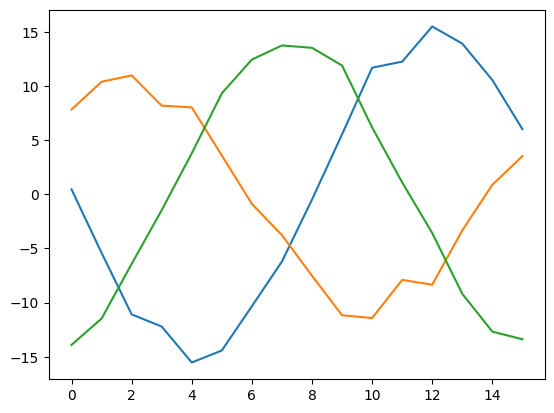

In [35]:
eventtt = 159623
plt.plot(dataset.__getitem__(eventtt)[0])
print(dataset.__getitem__(eventtt))

### 5. Model Training


##### 5.1. Train / Test(dev) Loop Creation


In [36]:
# Create Training / Test / Validation Loops


# Training
def train(dataloader, model, loss_fn, optimizer, return_loss=False):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if return_loss == True:
            loss_list.append(loss.item())
        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>f} [{current:>5d}/{size:>5d}]")

        if batch % 5 == 0:
            my_lr_scheduler.step()
    if return_loss == True:
        return loss_list


from torchmetrics.functional.classification import binary_stat_scores


def test_metrics(dataloader, model, loss_fn, return_metrics=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    conf_matrix = torch.zeros(1, 5, dtype=torch.int64).to(device)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)
            pred = model(x)

            conf_matrix = conf_matrix.add(binary_stat_scores(pred, y))
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    acc = (conf_matrix[0, 0] + conf_matrix[0, 2]) / conf_matrix[0, :-1].sum()
    correct /= size
    print(f"{correct*100:>0.1f}")
    print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if return_metrics == True:
        return conf_matrix, test_loss

##### 5.2. Training the model


In [40]:
# model.load_state_dict(torch.load("models\R2.pth"))
# model.load_state_dict(torch.load("./models/LSTMHarmonic_weights_R1_996.pth"))
# model.load_state_dict(torch.load('./models/LSTMHarmonic_weights_R2_978.pth'))
# model.load_state_dict(torch.load('./models/R2Currents_DB2.pth'))
epochs = 1

for epoch in range(epochs):

    print(f"Epoch {epoch+1}\n--------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer, return_loss=True)
#     conf_matrix, _ = test_metrics(test_dataloader, model, loss_fn, return_metrics=True)
# print(conf_matrix)

Epoch 1
--------------------------------


100%|██████████| 35/35 [06:11<00:00, 10.61s/it]

100.0
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.022397 

tensor([[241,   0, 307,   0, 241]])


In [56]:
def conf_matrix_metrics(conf_matrix: torch.LongTensor) -> dict:
    """
    Returns dictionary with metrics from a confusion matrix.

            Parameters:
                    conf_matrix (torch.Tensor): confusion matrix of dimension (1, 5)
                        [TP, FP, TN, FN, TP + FN]

            Returns:
                    metrics (dict): dictionary with following metrics:
                        metrics["TOTAL"] -> total amount of samples.
                        metrics["TPR"]   -> True Positive Rate,  sensibility, recall, hit-rate.
                        metrics["FPR"]   -> False Positive Rate, Fallout.
                        metrics["TNR"]   -> True Negative Rate,  specificity, selectivity
                        metrics["ACC"]   -> Accuracy.
                        metrics["PPV"]   -> Positive Predictive Value, Precision.
    """
    if conf_matrix.shape == (5,):
        conf_matrix = np.expand_dims(conf_matrix, axis=0)

    metrics = {}
    TP = int(conf_matrix[0, 0].item())
    FP = int(conf_matrix[0, 1].item())
    TN = int(conf_matrix[0, 2].item())
    FN = int(conf_matrix[0, 3].item())
    metrics["TP"] = TP
    metrics["FP"] = FP
    metrics["TN"] = TN
    metrics["FN"] = FN
    P = TP + FN
    N = TN + FP
    TOTAL = TP + FP + TN + FN
    metrics["TOTAL"] = TOTAL
    try:
        metrics["TPR"] = TP / (TP + FN)
    except ZeroDivisionError:
        metrics["TPR"] = "ZeroDivisionError"
    try:
        metrics["FPR"] = FP / (FP + TN)
        metrics["TNR"] = TN / (FP + TN)
    except ZeroDivisionError:
        metrics["FPR"] = "ZeroDivisionError"
        metrics["TNR"] = "ZeroDivisionError"
    metrics["ACC"] = (TP + TN) / (TOTAL)
    try:
        metrics["PPV"] = TP / (TP + FP)
    except ZeroDivisionError:
        print("No se puede obtener PPV, división por cero")
    return metrics


metrics = conf_matrix_metrics(conf_matrix)
print(round(metrics["ACC"] * 100, 1))
print(conf_matrix)

100.0
tensor([[14,  0,  0,  0, 14]])


##### 5.3. Training loss visualization


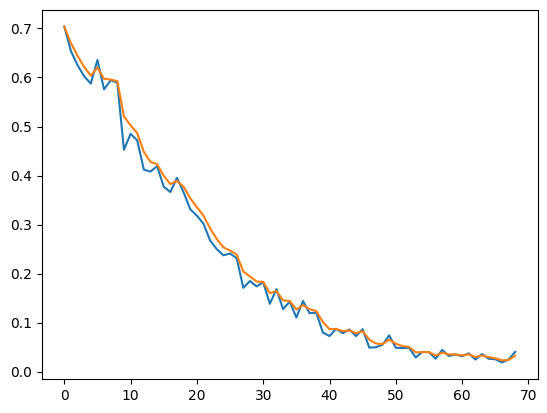

In [42]:
try:
    mini_batch_list = [index for index, _ in enumerate(train_loss)]
    train_loss_ewm = pd.DataFrame(train_loss).ewm(com=0.95).mean()
    plt.plot(mini_batch_list, train_loss, mini_batch_list, train_loss_ewm)
except NameError:
    print("Error! Run train loop")

##### 5.4. Saving the Model


In [38]:
# # Save the Model
# model.load_state_dict(torch.load('./models/R3Currents_DB2_V2.pth'))
# torch.save(model.state_dict(), "./models/paper_jan/R1Currents.pth")

### 6. Results Visualization


#### 6.1. Confussion Matrix Results Table Function


In [43]:
# Data visualization (CPU)


def confusion_matrix_labels(pred_label, true_label):
    label = ""
    if int(pred_label) == int(true_label):
        label += "T"
    else:
        label += "F"
    if pred_label == 1:
        label += "P"
    else:
        label += "N"
    return label


confusion_matrix_pandas = np.vectorize(confusion_matrix_labels)


def confusion_matrix(
    preds: torch.FloatTensor, labels: torch.FloatTensor
) -> pd.DataFrame:
    preds = preds.detach()
    labels = labels.detach()
    data = {
        "Pred probability": torch.reshape(preds, (-1,)).cpu().numpy(),
        "Pred label": torch.reshape(torch.round(preds), (-1,)).int().cpu().numpy(),
        "True label": torch.reshape(labels, (-1,)).int().cpu().numpy(),
    }
    df = pd.DataFrame(data)
    df["Result"] = confusion_matrix_pandas(df["Pred label"], df["True label"])
    return df

##### 6.2. Plotly Plot


In [58]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fs = 960
dataset_plot = Form1Dataset(
    dataset_dir,
    max_window_idx=max_window_idx,
    signal_names=signal_names,
    test=True,
    csv_step=csv_step,
    window_length=N,
)
plot_dataloader = DataLoader(dataset_plot, batch_size=train_batch_size, shuffle=True)

dataiter = iter(plot_dataloader)
signal_windows, t_windows, labels, csv_name, index, window_idx = next(dataiter)
print(len(csv_name))
print(window_idx.shape)
print(labels.shape)

print(labels.type())
x = model(signal_windows[0:9].to(device))
# x = x.detach()

# Crear Matriz de confusión
df = confusion_matrix(x, labels[0:9])
print(type(df))
print(df)

# figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
fig = make_subplots(rows=rows, cols=cols)

label_to_text = {
    "0": "No Fault",
    "1": "Fault",
}

for i in range(0, cols * rows):

    col = i % cols
    row = i // cols
    label = label_to_text[str(int(labels[i, 0].item()))]
    win_idx = str(window_idx[i].item())
    print(csv_name[i])
    fig.add_trace(
        go.Scatter(
            name=f"{label} - {win_idx} - {csv_name[i]}",
            x=t_windows[i, :],
            y=signal_windows[i, :, 0],
            marker_color="black",
        ),
        row=row + 1,
        col=col + 1,
    )

fig.update_layout(
    height=700,
    width=900,
    title_text="Figuras",
    margin={"b": 20, "t": 40, "l": 20, "r": 30},
    plot_bgcolor="rgba(0,0,0,0)",
    # paper_bgcolor="whitesmoke",
)
fig.show()

64
torch.Size([64])
torch.Size([64, 1])
torch.FloatTensor
<class 'pandas.core.frame.DataFrame'>
   Pred probability  Pred label  True label Result
0          0.016923           0           0     TN
1          0.011399           0           0     TN
2          0.011399           0           0     TN
3          0.898900           1           1     TP
4          0.905002           1           1     TP
5          0.014556           0           0     TN
6          0.923936           1           1     TP
7          0.019102           0           0     TN
8          0.011936           0           0     TN
L051.47_046.66.csv
L075.90_077.74.csv
L107.36_106.83.csv
Fault03_B224_RF40.00001_L064.08.csv
Fault05_B234_RF50.00001_L062.46.csv
L090.90_092.08.csv
Fault10_B866_RF60.00001_L057.35.csv
L092.61_090.32.csv
L064.18_063.13.csv


##### 6.3. Matplotlib Plots


d:\PaperLSTM\pyTorch\env\lib\site-packages\torch\utils\data\_utils\collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:205.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


   Pred probability  Pred label  True label Result
0          0.001318           0           0     TN
1          0.002034           0           0     TN
2          0.003675           0           0     TN
3          0.967257           1           1     TP
4          0.000910           0           0     TN
5          0.000788           0           0     TN
6          0.003412           0           0     TN
7          0.003351           0           0     TN
8          0.001897           0           0     TN


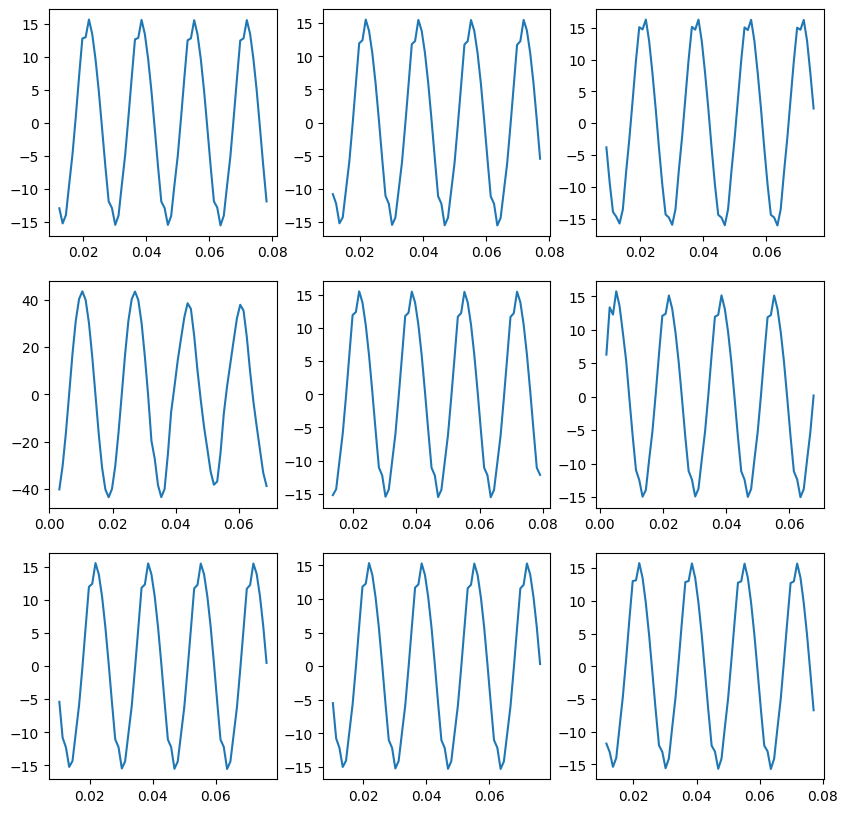

In [46]:
dataset_plot = Form1Dataset(
    dataset_dir,
    max_window_idx=max_window_idx,
    signal_names=signal_names,
    test=True,
    # step=4,
    csv_step=csv_step,
    window_length=N,
)
plot_dataloader = DataLoader(dataset_plot, batch_size=train_batch_size, shuffle=True)

dataiter = iter(plot_dataloader)
signal_windows, t_windows, labels, *_ = next(dataiter)
fs = 960

x = model(signal_windows[1:10].to(device))
x = x.detach()

# Crear Matriz de confusión
df = confusion_matrix(x, labels[1:10])
print(df)

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t_windows[i, :], signal_windows[i, :, 0])

### 7. Data Exploration


##### 7.1. Auxiliar Functions


In [47]:
def signal_exploration(idx: int, dataset, model, plot_signal: bool = True):
    signal, t, idx_min, idx_max, _ = dataset.get_event(idx)
    model.eval()
    if plot_signal == True:
        plt.plot(t, signal)
        plt.show()
    conf_matrix = torch.zeros(1, 5, dtype=torch.int64).to(device)
    preds = torch.empty((0, 1)).to(device)
    labels = torch.empty((0, 1)).to(device)
    for i in range(idx_min, idx_max + 1):
        signal, y = dataset.__getitem__(i)
        y = torch.unsqueeze(y, 0).to(device)
        signal = torch.unsqueeze(signal, 0).to(device)
        pred = model(signal)
        preds = torch.cat((preds, pred), 0)
        labels = torch.cat((labels, y), 0)
        conf_matrix = conf_matrix.add(binary_stat_scores(pred, y))
    df = confusion_matrix(preds, labels)
    df.insert(loc=0, column="event_idx", value=np.repeat(idx, idx_max - idx_min + 1))
    # df.insert(loc=0, column="window_idx", value=df.index)
    # df.insert(loc=0, column="indices", value=idxs)

    return df, conf_matrix


def plot_confusion_matrix(metrics):
    z = [[metrics["TP"], metrics["FN"]], [metrics["FP"], metrics["TN"]]]
    fig = px.imshow(
        z,
        text_auto=True,
        template="seaborn",
        labels=dict(x="Predicted Label", y="Real Label", color="Predictions"),
        x=["Positive", "Negative"],
        y=["Positive", "Negative"],
        width=400,
        height=300,
    )
    fig.show()


def print_metrics(metrics):
    print(f"{'Total windows:':.<30}{metrics['TOTAL']:4}")
    print(f"{'True Positives:':.<30}{metrics['TP']:4}")
    print(f"{'False Positives:':.<30}{metrics['FP']:4}")
    print(f"{'True Negatives:':.<30}{metrics['TN']:4}")
    print(f"{'False Negatives:':.<30}{metrics['FN']:4}")
    print(f"{'Accuracy:':.<30}{metrics['ACC']*100:>6.1f}%")
    print(f"{'True Positive Rate:':.<30}{metrics['TPR']*100:>6.1f}%")
    print(f"{'False Positive Rate:':.<30}{metrics['FPR']*100:>6.1f}%")
    print(f"{'True Negative Rate:':.<30}{metrics['TNR']*100:>6.1f}%")
    try:
        print(f"{'Positive Predictive Value:':.<30}{metrics['PPV']*100:>6.1f}%")
    except KeyError:
        print(f"PPV divided by 0. No positive class predicted")
    # metrics["PPV"]

##### 7.2. Data Exploration


In [48]:
# Seleccionar pesos de modelo
# model.load_state_dict(torch.load('./models/LSTMHarmonic_weights_R3_934.pth'))
# model.load_state_dict(torch.load("./models/LSTMHarmonic_weights_R1_996.pth"))
# model.load_state_dict(torch.load('./models/LSTMHarmonic_weights_R2_978.pth'))


signal_names = [current_R1A, current_R1B, current_R1C]
max_window_idx = max_window_idx
# model.load_state_dict(torch.load('models\R3Currents_DB2.pth'))

# Create Dataset
dataset = Form1Dataset(
    dataset_dir,
    max_window_idx=max_window_idx,
    signal_names=signal_names,
    dataset_size=1300,
    csv_step=csv_step,
    window_length=N,
)
# dataset = train_dataset

##### 7.4. Plot individual windows


##### 7.5. Whole Dataset Exploration


In [37]:
# model.load_state_dict(torch.load("./models/R2.pth"))

<All keys matched successfully>

In [49]:
# Create Dataframe with information about data
print(dataset.len_events())
conf_matrix = torch.zeros(0, 5, dtype=torch.int64).to(device)
for idx in tqdm(range(dataset.len_events())):
    # for idx in tqdm(range()):
    df, CM = signal_exploration(idx, dataset, model, plot_signal=False)
    conf_matrix = torch.cat((conf_matrix, CM))
    if idx == 0:
        dataset_df = df
    else:
        dataset_df = pd.concat([dataset_df, df])

dataset_df = dataset_df.reset_index()
dataset_df = dataset_df.rename(columns={"index": "window idx"})
conf_matrix_total = np.sum(conf_matrix.cpu().numpy(), axis=0)


# # Load Dataframe
# def load_df(i):
#     dataset_df = pd.read_parquet(f"parquet_data/R{i}_df.parquet")
#     conf_matrix_df = pd.read_parquet(f"parquet_data/R{i}_CM_df.parquet")
#     conf_matrix = np.load(f"parquet_data/R{i}_CM.npy", allow_pickle=False)
#     return dataset_df, conf_matrix_df, conf_matrix

# dataset_df, conf_matrix_df, conf_matrix = load_df(1)


# dataset_df = pd.read_parquet(f"parquet_data\R2_currents_DB2_df.parquet")
# conf_matrix_df = pd.read_parquet(f"parquet_data\R2_currents_DB2_CM_df.parquet")
# conf_matrix = np.load(f"parquet_data\R2_currents_DB2_CM.npy", allow_pickle=False)
# conf_matrix_total = np.sum(conf_matrix, axis=0)

conf_matrix_total = np.sum(conf_matrix, axis=0)
metrics = conf_matrix_metrics(conf_matrix_total)

1300


100%|██████████| 1300/1300 [2:33:10<00:00,  7.07s/it] 


TypeError: sum() received an invalid combination of arguments - got (axis=int, out=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: axis, out
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [50]:
# df and plots settings
pd.set_option("display.float_format", "{:.2%}".format)

pd.options.plotting.backend = "matplotlib"


# print(dataset_df)
pd.set_option("display.max_rows", 2000)
false_positive = dataset_df.query('Result == "FP"')
false_negative = dataset_df.query('Result == "FN"')
# sample_df = pd.concat([sample_df, sample_df])

false_positive_plot = false_positive.groupby(["window idx"])["window idx"].count()
false_negative_plot = false_negative.groupby(["window idx"])["window idx"].count()
# print(false_positive['Pred probability'].value_counts(bins=10, sort=False))


if len(false_positive_plot) > 0:
    print("FALSE POSITVES")
    print(false_positive)
    # print(false_positive.groupby(['event_idx'])['event_idx'].count())
    false_positive.groupby(["event_idx"])["event_idx"].count().plot(kind="bar")
    plt.show()
    false_positive_plot.plot(kind="bar", edgecolor="black")
    plt.show()
    false_positive["Pred probability"].value_counts(
        bins=[i * 0.1 for i in range(5, 11)], sort=False, normalize=True
    ).plot(kind="bar")
    plt.show()
if len(false_negative_plot) > 0:
    print("FALSE NEGATIVES")
    print(false_negative)
    # print(false_negative.groupby(['event_idx'])['event_idx'].count())
    false_negative.groupby(["event_idx"])["event_idx"].count().plot(kind="bar")
    plt.show()

    false_negative_plot.plot(kind="bar", edgecolor="black")
    plt.show()
    false_negative["Pred probability"].value_counts(
        bins=[i * 0.1 for i in range(6)], sort=False, normalize=True
    ).plot(kind="bar")
    plt.show()

plt.show()

In [51]:
# model.load_state_dict(torch.load('models\LSTMHarmonic_weights_R3Currents.pth'))
print(conf_matrix_total)
metrics = conf_matrix_metrics(conf_matrix_total)
print_metrics(metrics)
plot_confusion_matrix(metrics)

[8582    0 9618    0 8582]
Total windows:................18200
True Positives:...............8582
False Positives:..............   0
True Negatives:...............9618
False Negatives:..............   0
Accuracy:..................... 100.0%
True Positive Rate:........... 100.0%
False Positive Rate:..........   0.0%
True Negative Rate:........... 100.0%
Positive Predictive Value:.... 100.0%


##### 7.6. Save Dataframe and Confusion Matrix


In [53]:
dataset_df.to_parquet("parquet_data/paper_jan/R1_df.parquet")
conf_matrix_df = pd.DataFrame(
    conf_matrix.cpu(), columns=["TP", "FP", "TF", "FN", "TP + FN"]
)
conf_matrix_df.to_parquet("parquet_data/paper_jan/R1_CM_df.parquet")
np.save("parquet_data/paper_jan/R1_CM.npy", conf_matrix.cpu())

##### 7.7. Individual Sample Visualization


F_T_h\Fault10_B136_RF20.00001_L117.66.csv


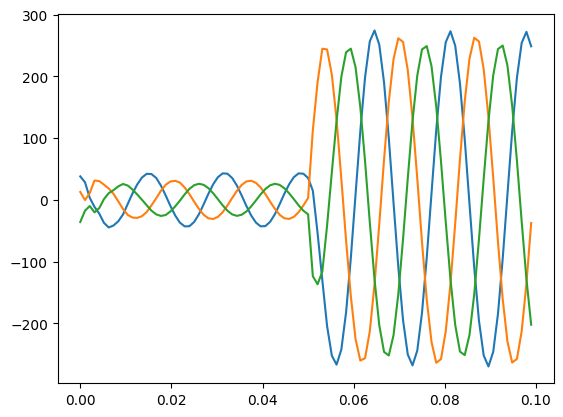

Confusion Matrix: tensor([[14,  0,  0,  0, 14]])
    event_idx  Pred probability  Pred label  True label Result
0         100            94.65%           1           1     TP
1         100            95.71%           1           1     TP
2         100            96.29%           1           1     TP
3         100            96.37%           1           1     TP
4         100            98.54%           1           1     TP
5         100            98.31%           1           1     TP
6         100            98.87%           1           1     TP
7         100            98.24%           1           1     TP
8         100            97.47%           1           1     TP
9         100            97.91%           1           1     TP
10        100            95.98%           1           1     TP
11        100            94.13%           1           1     TP
12        100            89.18%           1           1     TP
13        100            93.34%           1           1     TP


FALSE POSITVES
Empty DataFrame
Columns: [event_idx, Pred probability, Pred label, True label, Result]
Index: []

FALSE NEGATIVES
Empty DataFrame
Columns: [event_idx, Pred probability, Pred label, True label, Result]
Index: []


In [54]:
# Create signal_df
event_idx = 100
print(dataset.csv_list[event_idx])
sample_df, conf_matrix = signal_exploration(event_idx, dataset, model)
metrics = conf_matrix_metrics(conf_matrix)
print(f"Confusion Matrix: {conf_matrix}")
print(sample_df)
plot_confusion_matrix(metrics)
false_positive = sample_df.query('Result == "FP"')
false_negative = sample_df.query('Result == "FN"')
# sample_df = pd.concat([sample_df, sample_df])
print("FALSE POSITVES")
print(false_positive)
print("")
print("FALSE NEGATIVES")
print(false_negative)

In [55]:
window_idx = 56
sample_idx = (max_window_idx * event_idx) + window_idx


def update_fig(fig):
    fig.update_traces(line_color="#EEEEEE", line_width=2)
    fig.update_layout(
        paper_bgcolor="#222831",
        plot_bgcolor="#393E46",
        font_color="whitesmoke",
    )
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="#32E0C4")
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="#32E0C4")


signal, t = dataset.__getitem__(sample_idx, data_plot=True)
signal = np.copy(signal)
signal = signal.reshape((-1, 3))
signal = signal[:, 0]
t = np.copy(t)
print(type(t))
print(type(signal))
# print(f"Window index: {sample_df.query('indices == 196').index[0]}")
fig = px.line(
    x=t,
    y=signal,
    width=600,
    height=400,
    labels=dict(x="time", y="Amplitude"),
)
# update_fig(fig)x
fig.show()
fig = px.line(
    x=sample_df.index,
    y=sample_df["Pred label"],
    width=600,
    height=400,
    labels=dict(x="Window", y="Trip Signal"),
    line_shape="hv",
)
# update_fig(fig)
fig.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [62]:
import csv

with open("./dataset_lists/R2_list.csv", "w") as f:
    write = csv.writer(f)
    write.writerow(dataset.csv_list)

#### Por hacer

- Colocar tiempo en la gráfica de disparo


### 8. References

1. PyTorch Contributors: LSTM. [LSTM — PyTorch 1.13 documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
<!-- @online{LSTM,
    author = "{PyTorch Contributors}",
    title = "LSTM",
    url  = "https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html",
    addendum = "(accessed: 10.02.2023)",
    keywords = "LSTM pytorch"
} -->
